In [2]:

import numpy as np
import random
import matplotlib.pyplot as plt

## torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Subset



DATASET_PATH = "./data"
random.seed(42)
#Device
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# print("Device:", device)


#### Data Preparation : Partionning & preprocesing

## **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.


In [3]:
# Transform to normalized Tensors in the range [0,1]

transform = T.Compose([T.Pad(2) #to cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).
                       , T.ToTensor(), T.Normalize((0.5,), (0.5,))])

In [4]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=transform)
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=transform)

In [5]:
MNIST_train_dataset, MNIST_test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

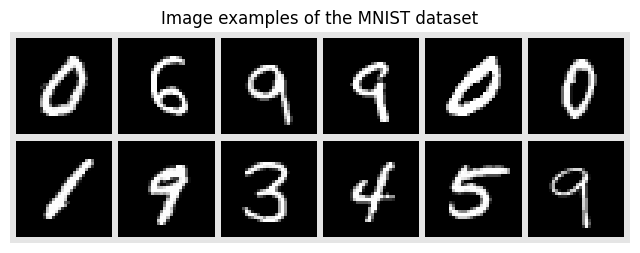

In [6]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [7]:
# use DataLoader to keep applied transformation when download the data..

MNIST_train_loader = torch.utils.data.DataLoader(MNIST_train_dataset, batch_size=64, shuffle=True)
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=64, shuffle=False)
# help(MNIST_train_loader)
#check stats :
data_iter = iter(MNIST_train_loader)
images, labels = next(data_iter)

mean = images.mean()
std = images.std()
min_val = images.min()
max_val = images.max()

print(f'Batch Mean: {mean.item()}')
print(f'Batch Std: {std.item()}')
print(f'Batch Min: {min_val.item()}')
print(f'Batch Max: {max_val.item()}')

Batch Mean: -0.794101893901825
Batch Std: 0.5581037998199463
Batch Min: -1.0
Batch Max: 1.0


In [8]:
train_images, train_labels = next(iter(MNIST_train_loader))
print(train_images.shape) 
print(train_labels.shape) 

torch.Size([64, 1, 32, 32])
torch.Size([64])


#### Baseline Model Setup : extent with limited labeled data

In [9]:
indices = np.random.permutation(len(MNIST_train_dataset))[:100]

train_100= Subset(MNIST_train_dataset, indices)
train_100_loader = DataLoader(train_100, batch_size=10, shuffle=True)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same")  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2)  
        self.dp1 = nn.Dropout(p=0.25) 
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=512)  
        self.dp2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=10) 

    def forward(self, x):
        x = F.relu(self.conv1(x))     
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = self.dp1(x)                 # Dropout1
        x = torch.flatten(x, 1)        
        x = F.relu(self.fc1(x))         
        x = self.dp2(x)                 
        x = self.fc2(x) #logits                
        return x

In [16]:
model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
num_epochs = 500
model.train() 
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_100_loader:
        optimizer.zero_grad()          
        outputs = model(images)        
        loss = criterion(outputs, labels) 
        loss.backward()                
        optimizer.step()              
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_100_loader):.4f}")

Epoch [1/500], Loss: 0.0978
Epoch [2/500], Loss: 0.0176
Epoch [3/500], Loss: 0.0438
Epoch [4/500], Loss: 0.0259
Epoch [5/500], Loss: 0.1331
Epoch [6/500], Loss: 0.0627
Epoch [7/500], Loss: 0.0278
Epoch [8/500], Loss: 0.0231
Epoch [9/500], Loss: 0.0284
Epoch [10/500], Loss: 0.0066
Epoch [11/500], Loss: 0.0131
Epoch [12/500], Loss: 0.0096
Epoch [13/500], Loss: 0.0133
Epoch [14/500], Loss: 0.0159
Epoch [15/500], Loss: 0.0050
Epoch [16/500], Loss: 0.0056
Epoch [17/500], Loss: 0.0014
Epoch [18/500], Loss: 0.0064
Epoch [19/500], Loss: 0.0044
Epoch [20/500], Loss: 0.0056
Epoch [21/500], Loss: 0.0015
Epoch [22/500], Loss: 0.0063
Epoch [23/500], Loss: 0.0015
Epoch [24/500], Loss: 0.0012
Epoch [25/500], Loss: 0.0006
Epoch [26/500], Loss: 0.0006
Epoch [27/500], Loss: 0.0005
Epoch [28/500], Loss: 0.0015
Epoch [29/500], Loss: 0.0052
Epoch [30/500], Loss: 0.0015
Epoch [31/500], Loss: 0.0026
Epoch [32/500], Loss: 0.0011
Epoch [33/500], Loss: 0.0062
Epoch [34/500], Loss: 0.0255
Epoch [35/500], Loss: 0

In [20]:
model.eval()  
correct = 0
total = 0

with torch.no_grad():
    for images, labels in MNIST_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

Accuracy on the test set: 81.92%
